EfficientNet V2 M

Import Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torch.cuda.amp import autocast, GradScaler
# from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
import os

In [2]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available! GPU: {torch.cuda.get_device_name(0)}")

    # Check if the GPU supports mixed precision (AMP)
    compute_capability = torch.cuda.get_device_capability(device)
    print(f"Compute Capability: {compute_capability}")

    if compute_capability[0] >= 7:  # Tensor Cores require Compute Capability 7.0+
        print("✅ Your GPU supports Mixed Precision Training (AMP)!")
    else:
        print("❌ Your GPU does NOT fully support Mixed Precision Training.")
else:
    print("❌ CUDA is not available. Running on CPU.")

CUDA is available! GPU: NVIDIA GeForce RTX 4060 Ti
Compute Capability: (8, 9)
✅ Your GPU supports Mixed Precision Training (AMP)!


In [3]:
# Define custom dataset path and constants
data_dir = 'C:/Dhika TA/clahe-dataset (split)'  # Replace with your dataset path
num_classes = 3 # Three classes because of only three grades
batch_size = 8 # Sets the number of images per batch. High number uses more memory and allows less chances for model to update gradients
num_epochs = 50
learning_rate = 0.001 # Sets the initial learning rate that causes the model to update gradients.
top_k = 3  # For top-k accuracy

# Define checkpoint directory
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

Dataset Management

In [4]:
# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root=f'{data_dir}/val', transform=val_transforms)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Loading Model

In [5]:
# Load EfficientNet V2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_v2_m(weights='IMAGENET1K_V1')

# Get input features from the last layer
in_features = model.classifier[1].in_features  # Extracts 1280 features
model.classifier = nn.Sequential(
    # nn.Dropout(p=0.4),  # Increased dropout (try between 0.3 - 0.5)
    nn.Linear(in_features, num_classes)  # Adjust to your number of classes
)

model = model.to(device)

# Enable Torch 2.0 compilation for faster training
# model = torch.compile(model)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-5,  # Minimum LR
    max_lr=1e-3,   # Maximum LR
    step_size_up=10,
    mode="triangular2"
)

print("Model is on:", next(model.parameters()).device)

Model is on: cuda:0


Initial Variables

In [6]:
# Training and validation
best_val_accuracy = 0.0
class_names = train_dataset.classes

# Metrics for plotting
train_accuracies = []
val_accuracies = []
top_k_accuracies = []

torch.cuda.empty_cache()

Helper Functions

In [7]:
# Function to save checkpoint
def save_checkpoint(epoch, model, optimizer, scheduler, best_val_accuracy, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_accuracy': best_val_accuracy,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'top_k_accuracies': top_k_accuracies
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, filename))

# Function to load checkpoint
def load_checkpoint(model, optimizer, scheduler, filename='checkpoint.pth'):
    checkpoint = torch.load(os.path.join(checkpoint_dir, filename))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    best_val_accuracy = checkpoint['best_val_accuracy']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']
    top_k_accuracies = checkpoint['top_k_accuracies']
    return epoch, best_val_accuracy, train_accuracies, val_accuracies, top_k_accuracies

def calculate_metrics(y_true, y_pred, class_names):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names)
    return conf_matrix, accuracy, report

def top_k_accuracy(output, target, k=3):
    with torch.no_grad():
        _, pred = output.topk(k, dim=1)
        correct = pred.eq(target.view(-1, 1).expand_as(pred))
        return correct.sum().item() / target.size(0)

Checkpointing

In [8]:
# Check if a checkpoint exists and load it
checkpoint_filename = 'checkpoint.pth'
start_epoch = 0
if os.path.exists(os.path.join(checkpoint_dir, checkpoint_filename)):
    print("Loading checkpoint...")
    start_epoch, best_val_accuracy, train_accuracies, val_accuracies, top_k_accuracies = load_checkpoint(model, optimizer, scheduler, checkpoint_filename)
    print(f"Resuming training from epoch {start_epoch + 1}")
else:
    print("No checkpoint found. Starting training from scratch.")

# Check if best_model.pth or last_model.pth exists
best_model_path = 'best_model.pth'
last_model_path = 'last_model.pth'

if os.path.exists(best_model_path):
    print("Loading best model...")
    model.load_state_dict(torch.load(best_model_path))
    print("Resuming training from the best model.")
elif os.path.exists(last_model_path):
    print("Loading last model...")
    model.load_state_dict(torch.load(last_model_path))
    print("Resuming training from the last model.")
elif os.path.exists(os.path.join(checkpoint_dir, checkpoint_filename)):
    print("Loading checkpoint...")
    start_epoch, best_val_accuracy, train_accuracies, val_accuracies, top_k_accuracies = load_checkpoint(model, optimizer, scheduler, checkpoint_filename)
    print(f"Resuming training from epoch {start_epoch + 1}")
else:
    print("No checkpoint or model found. Starting training from scratch.")


No checkpoint found. Starting training from scratch.
No checkpoint or model found. Starting training from scratch.


Training and Validation Loops

In [ ]:
# Enables CuDNN benchmarking, which optimizes GPU performance by selecting the fastest convolution algorithms for your model.
# Helps if input sizes don’t change much (like the fixed 480x480 images).
torch.backends.cudnn.benchmark = True

# writer = SummaryWriter(log_dir="runs/efficientnet_v2_m")

# Training and validation loop with checkpoint saving
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    scaler = GradScaler()  # Initialize gradient scaler

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):

        # Mixed Precision Training
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        with autocast():  # Enable mixed precision
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()  # Scale gradients to prevent underflow
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # ✅ Prevent exploding gradients
        scaler.step(optimizer)  # Update weights
        scaler.update()  # Adjust scaling factor

        # ✅ Update loss and accuracy tracking
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_accuracies.append(epoch_acc.item())

    print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    # ✅ Log training loss and accuracy to TensorBoard
    # writer.add_scalar("Loss/train", epoch_loss, epoch)
    # writer.add_scalar("Accuracy/train", epoch_acc, epoch)

    # ================= Validation ==================
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    top_k_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            top_k_corrects += top_k_accuracy(outputs, labels, k=top_k) * labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss /= len(val_dataset)
    val_accuracy = val_corrects.double() / len(val_dataset)
    val_top_k_accuracy = top_k_corrects / len(val_dataset)  # ✅ Divide by total validation samples
    val_accuracies.append(val_accuracy.item())
    top_k_accuracies.append(val_top_k_accuracy)

    conf_matrix, accuracy, report = calculate_metrics(all_labels, all_preds, class_names)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Top-{top_k} Accuracy: {val_top_k_accuracy:.4f}")
    print("Classification Report:\n", report)

    # ✅ Log validation loss and accuracy to TensorBoard
    # writer.add_scalar("Loss/val", val_loss, epoch)
    # writer.add_scalar("Accuracy/val", val_accuracy, epoch)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved Best Model")

    # Save checkpoint at the end of each epoch
    save_checkpoint(epoch, model, optimizer, scheduler, best_val_accuracy, checkpoint_filename)
    print(f"Checkpoint saved at epoch {epoch + 1}")

    torch.save(model.state_dict(), 'last_model.pth')

    # writer.add_scalar("Learning Rate", optimizer.param_groups[0]['lr'], epoch)  # ✅ Log before LR update
    scheduler.step()

# writer.close()  # ✅ Closes TensorBoard writer

# Open terminal and run tensorboard --logdir=runs

Epoch 1/50 - Training: 100%|██████████| 1260/1260 [03:49<00:00,  5.48it/s]


Training Loss: 0.9226, Training Accuracy: 0.5566


Epoch 1/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.14it/s]


Validation Loss: 0.6593, Validation Accuracy: 0.7177, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.66      0.69      0.67       418
     Grade B       0.66      0.72      0.69       422
     Grade C       0.86      0.75      0.80       421

    accuracy                           0.72      1261
   macro avg       0.73      0.72      0.72      1261
weighted avg       0.73      0.72      0.72      1261

Saved Best Model
Checkpoint saved at epoch 1


Epoch 2/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.5397, Training Accuracy: 0.7830


Epoch 2/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.33it/s]


Validation Loss: 0.6004, Validation Accuracy: 0.8898, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.82      0.95      0.88       418
     Grade B       0.91      0.81      0.86       422
     Grade C       0.96      0.91      0.93       421

    accuracy                           0.89      1261
   macro avg       0.90      0.89      0.89      1261
weighted avg       0.90      0.89      0.89      1261

Saved Best Model
Checkpoint saved at epoch 2


Epoch 3/50 - Training: 100%|██████████| 1260/1260 [03:42<00:00,  5.65it/s]


Training Loss: 0.3767, Training Accuracy: 0.8616


Epoch 3/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.28it/s]


Validation Loss: 3.6278, Validation Accuracy: 0.8874, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.83      0.93      0.88       418
     Grade B       0.91      0.81      0.86       422
     Grade C       0.93      0.92      0.93       421

    accuracy                           0.89      1261
   macro avg       0.89      0.89      0.89      1261
weighted avg       0.89      0.89      0.89      1261

Checkpoint saved at epoch 3


Epoch 4/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.5737, Training Accuracy: 0.7736


Epoch 4/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.16it/s]


Validation Loss: 1.7448, Validation Accuracy: 0.8057, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.89      0.60      0.72       418
     Grade B       0.68      0.92      0.79       422
     Grade C       0.92      0.89      0.91       421

    accuracy                           0.81      1261
   macro avg       0.83      0.81      0.80      1261
weighted avg       0.83      0.81      0.80      1261

Checkpoint saved at epoch 4


Epoch 5/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.3394, Training Accuracy: 0.8859


Epoch 5/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.20it/s]


Validation Loss: 0.4466, Validation Accuracy: 0.8787, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.86      0.86      0.86       418
     Grade B       0.86      0.82      0.84       422
     Grade C       0.91      0.96      0.94       421

    accuracy                           0.88      1261
   macro avg       0.88      0.88      0.88      1261
weighted avg       0.88      0.88      0.88      1261

Checkpoint saved at epoch 5


Epoch 6/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.3942, Training Accuracy: 0.8632


Epoch 6/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.24it/s]


Validation Loss: 0.4509, Validation Accuracy: 0.8414, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.87      0.78      0.83       418
     Grade B       0.73      0.91      0.81       422
     Grade C       0.97      0.83      0.90       421

    accuracy                           0.84      1261
   macro avg       0.86      0.84      0.84      1261
weighted avg       0.86      0.84      0.84      1261

Checkpoint saved at epoch 6


Epoch 7/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.4230, Training Accuracy: 0.8504


Epoch 7/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.21it/s]


Validation Loss: 0.2910, Validation Accuracy: 0.8874, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.90      0.86      0.88       418
     Grade B       0.87      0.86      0.86       422
     Grade C       0.88      0.95      0.92       421

    accuracy                           0.89      1261
   macro avg       0.89      0.89      0.89      1261
weighted avg       0.89      0.89      0.89      1261

Checkpoint saved at epoch 7


Epoch 8/50 - Training: 100%|██████████| 1260/1260 [03:42<00:00,  5.67it/s]


Training Loss: 0.4243, Training Accuracy: 0.8499


Epoch 8/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.21it/s]


Validation Loss: 0.5106, Validation Accuracy: 0.8136, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.72      0.91      0.80       418
     Grade B       0.82      0.63      0.72       422
     Grade C       0.93      0.90      0.91       421

    accuracy                           0.81      1261
   macro avg       0.82      0.81      0.81      1261
weighted avg       0.82      0.81      0.81      1261

Checkpoint saved at epoch 8


Epoch 9/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.4313, Training Accuracy: 0.8456


Epoch 9/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.14it/s]


Validation Loss: 0.7581, Validation Accuracy: 0.7811, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.80      0.72      0.76       418
     Grade B       0.74      0.72      0.73       422
     Grade C       0.80      0.90      0.85       421

    accuracy                           0.78      1261
   macro avg       0.78      0.78      0.78      1261
weighted avg       0.78      0.78      0.78      1261

Checkpoint saved at epoch 9


Epoch 10/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.6033, Training Accuracy: 0.7622


Epoch 10/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.21it/s]


Validation Loss: 0.5551, Validation Accuracy: 0.7803, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.78      0.71      0.74       418
     Grade B       0.69      0.79      0.73       422
     Grade C       0.89      0.85      0.87       421

    accuracy                           0.78      1261
   macro avg       0.79      0.78      0.78      1261
weighted avg       0.79      0.78      0.78      1261

Checkpoint saved at epoch 10


Epoch 11/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.3534, Training Accuracy: 0.8764


Epoch 11/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.23it/s]


Validation Loss: 0.6242, Validation Accuracy: 0.8033, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.78      0.85      0.81       418
     Grade B       0.89      0.62      0.73       422
     Grade C       0.78      0.94      0.85       421

    accuracy                           0.80      1261
   macro avg       0.81      0.80      0.80      1261
weighted avg       0.82      0.80      0.80      1261

Checkpoint saved at epoch 11


Epoch 12/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.3614, Training Accuracy: 0.8762


Epoch 12/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.29it/s]


Validation Loss: 0.3678, Validation Accuracy: 0.8818, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.88      0.86      0.87       418
     Grade B       0.89      0.81      0.85       422
     Grade C       0.88      0.97      0.92       421

    accuracy                           0.88      1261
   macro avg       0.88      0.88      0.88      1261
weighted avg       0.88      0.88      0.88      1261

Checkpoint saved at epoch 12


Epoch 13/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.3537, Training Accuracy: 0.9025


Epoch 13/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.18it/s]


Validation Loss: 0.5946, Validation Accuracy: 0.8525, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.95      0.70      0.80       418
     Grade B       0.81      0.87      0.84       422
     Grade C       0.83      0.99      0.90       421

    accuracy                           0.85      1261
   macro avg       0.86      0.85      0.85      1261
weighted avg       0.86      0.85      0.85      1261

Checkpoint saved at epoch 13


Epoch 14/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.4079, Training Accuracy: 0.8952


Epoch 14/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.24it/s]


Validation Loss: 0.6443, Validation Accuracy: 0.8303, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.94      0.62      0.75       418
     Grade B       0.71      0.91      0.80       422
     Grade C       0.91      0.96      0.93       421

    accuracy                           0.83      1261
   macro avg       0.85      0.83      0.83      1261
weighted avg       0.85      0.83      0.83      1261

Checkpoint saved at epoch 14


Epoch 15/50 - Training: 100%|██████████| 1260/1260 [03:42<00:00,  5.67it/s]


Training Loss: 0.3582, Training Accuracy: 0.9212


Epoch 15/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.19it/s]


Validation Loss: 0.9509, Validation Accuracy: 0.8953, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.83      0.91      0.87       418
     Grade B       0.92      0.80      0.86       422
     Grade C       0.94      0.97      0.96       421

    accuracy                           0.90      1261
   macro avg       0.90      0.90      0.89      1261
weighted avg       0.90      0.90      0.89      1261

Saved Best Model
Checkpoint saved at epoch 15


Epoch 16/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.3384, Training Accuracy: 0.9563


Epoch 16/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.22it/s]


Validation Loss: 1.1363, Validation Accuracy: 0.9025, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.82      0.97      0.89       418
     Grade B       0.92      0.82      0.87       422
     Grade C       0.99      0.92      0.95       421

    accuracy                           0.90      1261
   macro avg       0.91      0.90      0.90      1261
weighted avg       0.91      0.90      0.90      1261

Saved Best Model
Checkpoint saved at epoch 16


Epoch 17/50 - Training: 100%|██████████| 1260/1260 [03:42<00:00,  5.67it/s]


Training Loss: 0.2027, Training Accuracy: 0.9771


Epoch 17/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.25it/s]


Validation Loss: 0.8325, Validation Accuracy: 0.9326, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.94      0.89      0.91       418
     Grade B       0.90      0.92      0.91       422
     Grade C       0.96      0.99      0.97       421

    accuracy                           0.93      1261
   macro avg       0.93      0.93      0.93      1261
weighted avg       0.93      0.93      0.93      1261

Saved Best Model
Checkpoint saved at epoch 17


Epoch 18/50 - Training: 100%|██████████| 1260/1260 [03:40<00:00,  5.70it/s]


Training Loss: 0.1971, Training Accuracy: 0.9792


Epoch 18/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.27it/s]


Validation Loss: 0.9957, Validation Accuracy: 0.9286, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.92      0.92      0.92       418
     Grade B       0.92      0.88      0.90       422
     Grade C       0.94      0.99      0.97       421

    accuracy                           0.93      1261
   macro avg       0.93      0.93      0.93      1261
weighted avg       0.93      0.93      0.93      1261

Checkpoint saved at epoch 18


Epoch 19/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.70it/s]


Training Loss: 0.1161, Training Accuracy: 0.9853


Epoch 19/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.12it/s]


Validation Loss: 0.7896, Validation Accuracy: 0.9485, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.94      0.94      0.94       418
     Grade B       0.94      0.92      0.93       422
     Grade C       0.97      0.99      0.98       421

    accuracy                           0.95      1261
   macro avg       0.95      0.95      0.95      1261
weighted avg       0.95      0.95      0.95      1261

Saved Best Model
Checkpoint saved at epoch 19


Epoch 20/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.0404, Training Accuracy: 0.9934


Epoch 20/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.26it/s]


Validation Loss: 0.7173, Validation Accuracy: 0.9603, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.94      0.96      0.95       418
     Grade B       0.96      0.93      0.94       422
     Grade C       0.99      0.99      0.99       421

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

Saved Best Model
Checkpoint saved at epoch 20


Epoch 21/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.0187, Training Accuracy: 0.9959


Epoch 21/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.26it/s]


Validation Loss: 0.7127, Validation Accuracy: 0.9532, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.92      0.96      0.94       418
     Grade B       0.96      0.91      0.93       422
     Grade C       0.98      0.99      0.98       421

    accuracy                           0.95      1261
   macro avg       0.95      0.95      0.95      1261
weighted avg       0.95      0.95      0.95      1261

Checkpoint saved at epoch 21


Epoch 22/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.70it/s]


Training Loss: 0.0271, Training Accuracy: 0.9954


Epoch 22/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.25it/s]


Validation Loss: 0.6220, Validation Accuracy: 0.9540, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.96      0.92      0.94       418
     Grade B       0.93      0.95      0.94       422
     Grade C       0.97      0.99      0.98       421

    accuracy                           0.95      1261
   macro avg       0.95      0.95      0.95      1261
weighted avg       0.95      0.95      0.95      1261

Checkpoint saved at epoch 22


Epoch 23/50 - Training: 100%|██████████| 1260/1260 [03:40<00:00,  5.71it/s]


Training Loss: 0.0178, Training Accuracy: 0.9972


Epoch 23/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.17it/s]


Validation Loss: 0.7696, Validation Accuracy: 0.9516, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.94      0.94      0.94       418
     Grade B       0.94      0.93      0.93       422
     Grade C       0.97      0.99      0.98       421

    accuracy                           0.95      1261
   macro avg       0.95      0.95      0.95      1261
weighted avg       0.95      0.95      0.95      1261

Checkpoint saved at epoch 23


Epoch 24/50 - Training: 100%|██████████| 1260/1260 [03:40<00:00,  5.70it/s]


Training Loss: 0.0348, Training Accuracy: 0.9956


Epoch 24/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.28it/s]


Validation Loss: 0.6561, Validation Accuracy: 0.9572, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.95      0.94      0.95       418
     Grade B       0.95      0.94      0.94       422
     Grade C       0.97      0.99      0.98       421

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

Checkpoint saved at epoch 24


Epoch 25/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.0368, Training Accuracy: 0.9952


Epoch 25/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.24it/s]


Validation Loss: 1.0329, Validation Accuracy: 0.9469, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.91      0.96      0.93       418
     Grade B       0.95      0.90      0.92       422
     Grade C       0.98      0.98      0.98       421

    accuracy                           0.95      1261
   macro avg       0.95      0.95      0.95      1261
weighted avg       0.95      0.95      0.95      1261

Checkpoint saved at epoch 25


Epoch 26/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.70it/s]


Training Loss: 0.1053, Training Accuracy: 0.9880


Epoch 26/50 - Validation: 100%|██████████| 158/158 [00:31<00:00,  4.95it/s]


Validation Loss: 0.8683, Validation Accuracy: 0.9397, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.94      0.92      0.93       418
     Grade B       0.93      0.91      0.92       422
     Grade C       0.95      0.99      0.97       421

    accuracy                           0.94      1261
   macro avg       0.94      0.94      0.94      1261
weighted avg       0.94      0.94      0.94      1261

Checkpoint saved at epoch 26


Epoch 27/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.70it/s]


Training Loss: 0.1697, Training Accuracy: 0.9822


Epoch 27/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.31it/s]


Validation Loss: 0.9020, Validation Accuracy: 0.9461, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.91      0.97      0.94       418
     Grade B       0.95      0.89      0.92       422
     Grade C       0.99      0.98      0.98       421

    accuracy                           0.95      1261
   macro avg       0.95      0.95      0.95      1261
weighted avg       0.95      0.95      0.95      1261

Checkpoint saved at epoch 27


Epoch 28/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.1312, Training Accuracy: 0.9860


Epoch 28/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.25it/s]


Validation Loss: 1.5840, Validation Accuracy: 0.9144, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.83      0.97      0.89       418
     Grade B       0.95      0.82      0.88       422
     Grade C       0.99      0.95      0.97       421

    accuracy                           0.91      1261
   macro avg       0.92      0.91      0.91      1261
weighted avg       0.92      0.91      0.91      1261

Checkpoint saved at epoch 28


Epoch 29/50 - Training: 100%|██████████| 1260/1260 [03:57<00:00,  5.32it/s]


Training Loss: 0.2097, Training Accuracy: 0.9782


Epoch 29/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.25it/s]


Validation Loss: 0.8985, Validation Accuracy: 0.9278, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.93      0.89      0.91       418
     Grade B       0.89      0.92      0.90       422
     Grade C       0.97      0.97      0.97       421

    accuracy                           0.93      1261
   macro avg       0.93      0.93      0.93      1261
weighted avg       0.93      0.93      0.93      1261

Checkpoint saved at epoch 29


Epoch 30/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.2200, Training Accuracy: 0.9767


Epoch 30/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.24it/s]


Validation Loss: 1.1189, Validation Accuracy: 0.9310, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.92      0.92      0.92       418
     Grade B       0.93      0.90      0.91       422
     Grade C       0.95      0.98      0.96       421

    accuracy                           0.93      1261
   macro avg       0.93      0.93      0.93      1261
weighted avg       0.93      0.93      0.93      1261

Checkpoint saved at epoch 30


Epoch 31/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.4467, Training Accuracy: 0.9355


Epoch 31/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.21it/s]


Validation Loss: 1.2708, Validation Accuracy: 0.9017, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.92      0.85      0.88       418
     Grade B       0.90      0.87      0.89       422
     Grade C       0.88      0.98      0.93       421

    accuracy                           0.90      1261
   macro avg       0.90      0.90      0.90      1261
weighted avg       0.90      0.90      0.90      1261

Checkpoint saved at epoch 31


Epoch 32/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.1114, Training Accuracy: 0.9849


Epoch 32/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.25it/s]


Validation Loss: 0.5975, Validation Accuracy: 0.9556, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.96      0.94      0.95       418
     Grade B       0.94      0.94      0.94       422
     Grade C       0.97      0.99      0.98       421

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

Checkpoint saved at epoch 32


Epoch 33/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.70it/s]


Training Loss: 0.0511, Training Accuracy: 0.9934


Epoch 33/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.31it/s]


Validation Loss: 0.8653, Validation Accuracy: 0.9461, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.94      0.93      0.93       418
     Grade B       0.93      0.92      0.93       422
     Grade C       0.97      0.98      0.98       421

    accuracy                           0.95      1261
   macro avg       0.95      0.95      0.95      1261
weighted avg       0.95      0.95      0.95      1261

Checkpoint saved at epoch 33


Epoch 34/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.1097, Training Accuracy: 0.9884


Epoch 34/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.30it/s]


Validation Loss: 1.0116, Validation Accuracy: 0.9350, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.90      0.93      0.91       418
     Grade B       0.92      0.90      0.91       422
     Grade C       0.99      0.98      0.98       421

    accuracy                           0.93      1261
   macro avg       0.94      0.93      0.94      1261
weighted avg       0.94      0.93      0.94      1261

Checkpoint saved at epoch 34


Epoch 35/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.0535, Training Accuracy: 0.9920


Epoch 35/50 - Validation: 100%|██████████| 158/158 [00:33<00:00,  4.73it/s]


Validation Loss: 0.7981, Validation Accuracy: 0.9477, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.97      0.90      0.94       418
     Grade B       0.92      0.95      0.93       422
     Grade C       0.96      0.99      0.97       421

    accuracy                           0.95      1261
   macro avg       0.95      0.95      0.95      1261
weighted avg       0.95      0.95      0.95      1261

Checkpoint saved at epoch 35


Epoch 36/50 - Training: 100%|██████████| 1260/1260 [03:43<00:00,  5.64it/s]


Training Loss: 0.0796, Training Accuracy: 0.9910


Epoch 36/50 - Validation: 100%|██████████| 158/158 [00:32<00:00,  4.88it/s]


Validation Loss: 0.8527, Validation Accuracy: 0.9508, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.93      0.94      0.94       418
     Grade B       0.95      0.93      0.94       422
     Grade C       0.97      0.98      0.98       421

    accuracy                           0.95      1261
   macro avg       0.95      0.95      0.95      1261
weighted avg       0.95      0.95      0.95      1261

Checkpoint saved at epoch 36


Epoch 37/50 - Training: 100%|██████████| 1260/1260 [03:42<00:00,  5.67it/s]


Training Loss: 0.0637, Training Accuracy: 0.9918


Epoch 37/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.25it/s]


Validation Loss: 0.6115, Validation Accuracy: 0.9548, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.96      0.93      0.94       418
     Grade B       0.93      0.95      0.94       422
     Grade C       0.97      0.98      0.98       421

    accuracy                           0.95      1261
   macro avg       0.95      0.95      0.95      1261
weighted avg       0.95      0.95      0.95      1261

Checkpoint saved at epoch 37


Epoch 38/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.0277, Training Accuracy: 0.9961


Epoch 38/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.25it/s]


Validation Loss: 0.6435, Validation Accuracy: 0.9603, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.95      0.95      0.95       418
     Grade B       0.95      0.94      0.94       422
     Grade C       0.98      0.98      0.98       421

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

Checkpoint saved at epoch 38


Epoch 39/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.70it/s]


Training Loss: 0.0207, Training Accuracy: 0.9963


Epoch 39/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.28it/s]


Validation Loss: 0.6096, Validation Accuracy: 0.9611, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.94      0.97      0.95       418
     Grade B       0.97      0.92      0.95       422
     Grade C       0.97      0.99      0.98       421

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

Saved Best Model
Checkpoint saved at epoch 39


Epoch 40/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.70it/s]


Training Loss: 0.0136, Training Accuracy: 0.9966


Epoch 40/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.32it/s]


Validation Loss: 0.5764, Validation Accuracy: 0.9651, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.97      0.94      0.95       418
     Grade B       0.95      0.96      0.95       422
     Grade C       0.98      1.00      0.99       421

    accuracy                           0.97      1261
   macro avg       0.97      0.97      0.97      1261
weighted avg       0.97      0.97      0.97      1261

Saved Best Model
Checkpoint saved at epoch 40


Epoch 41/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.70it/s]


Training Loss: 0.0169, Training Accuracy: 0.9970


Epoch 41/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.26it/s]


Validation Loss: 0.5857, Validation Accuracy: 0.9675, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.96      0.96      0.96       418
     Grade B       0.95      0.95      0.95       422
     Grade C       0.99      0.99      0.99       421

    accuracy                           0.97      1261
   macro avg       0.97      0.97      0.97      1261
weighted avg       0.97      0.97      0.97      1261

Saved Best Model
Checkpoint saved at epoch 41


Epoch 42/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.70it/s]


Training Loss: 0.0155, Training Accuracy: 0.9968


Epoch 42/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.25it/s]


Validation Loss: 0.5705, Validation Accuracy: 0.9643, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.95      0.96      0.95       418
     Grade B       0.96      0.94      0.95       422
     Grade C       0.99      0.99      0.99       421

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

Checkpoint saved at epoch 42


Epoch 43/50 - Training: 100%|██████████| 1260/1260 [03:42<00:00,  5.68it/s]


Training Loss: 0.0136, Training Accuracy: 0.9971


Epoch 43/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.20it/s]


Validation Loss: 0.5672, Validation Accuracy: 0.9683, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.95      0.96      0.96       418
     Grade B       0.96      0.95      0.95       422
     Grade C       0.99      0.99      0.99       421

    accuracy                           0.97      1261
   macro avg       0.97      0.97      0.97      1261
weighted avg       0.97      0.97      0.97      1261

Saved Best Model
Checkpoint saved at epoch 43


Epoch 44/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.68it/s]


Training Loss: 0.0163, Training Accuracy: 0.9967


Epoch 44/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.29it/s]


Validation Loss: 0.6199, Validation Accuracy: 0.9627, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.93      0.97      0.95       418
     Grade B       0.96      0.93      0.94       422
     Grade C       1.00      0.99      0.99       421

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

Checkpoint saved at epoch 44


Epoch 45/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.0120, Training Accuracy: 0.9968


Epoch 45/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.25it/s]


Validation Loss: 0.5639, Validation Accuracy: 0.9659, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.92      0.98      0.95       418
     Grade B       0.98      0.93      0.95       422
     Grade C       1.00      0.99      0.99       421

    accuracy                           0.97      1261
   macro avg       0.97      0.97      0.97      1261
weighted avg       0.97      0.97      0.97      1261

Checkpoint saved at epoch 45


Epoch 46/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.70it/s]


Training Loss: 0.0233, Training Accuracy: 0.9960


Epoch 46/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.28it/s]


Validation Loss: 0.5648, Validation Accuracy: 0.9667, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.96      0.96      0.96       418
     Grade B       0.96      0.95      0.95       422
     Grade C       0.99      0.99      0.99       421

    accuracy                           0.97      1261
   macro avg       0.97      0.97      0.97      1261
weighted avg       0.97      0.97      0.97      1261

Checkpoint saved at epoch 46


Epoch 47/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.0143, Training Accuracy: 0.9963


Epoch 47/50 - Validation: 100%|██████████| 158/158 [00:30<00:00,  5.25it/s]


Validation Loss: 0.7317, Validation Accuracy: 0.9588, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.92      0.98      0.95       418
     Grade B       0.97      0.92      0.94       422
     Grade C       0.99      0.98      0.98       421

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

Checkpoint saved at epoch 47


Epoch 48/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.0147, Training Accuracy: 0.9962


Epoch 48/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.30it/s]


Validation Loss: 0.7769, Validation Accuracy: 0.9603, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.96      0.95      0.95       418
     Grade B       0.96      0.94      0.95       422
     Grade C       0.97      0.99      0.98       421

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

Checkpoint saved at epoch 48


Epoch 49/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.0998, Training Accuracy: 0.9901


Epoch 49/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.27it/s]


Validation Loss: 0.8370, Validation Accuracy: 0.9477, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.93      0.95      0.94       418
     Grade B       0.95      0.90      0.93       422
     Grade C       0.96      0.99      0.98       421

    accuracy                           0.95      1261
   macro avg       0.95      0.95      0.95      1261
weighted avg       0.95      0.95      0.95      1261

Checkpoint saved at epoch 49


Epoch 50/50 - Training: 100%|██████████| 1260/1260 [03:41<00:00,  5.69it/s]


Training Loss: 0.0330, Training Accuracy: 0.9948


Epoch 50/50 - Validation: 100%|██████████| 158/158 [00:29<00:00,  5.27it/s]


Validation Loss: 0.7161, Validation Accuracy: 0.9588, Top-3 Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

     Grade A       0.93      0.96      0.95       418
     Grade B       0.97      0.92      0.94       422
     Grade C       0.98      0.99      0.99       421

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

Checkpoint saved at epoch 50


Accuracy Over Epochs Graph

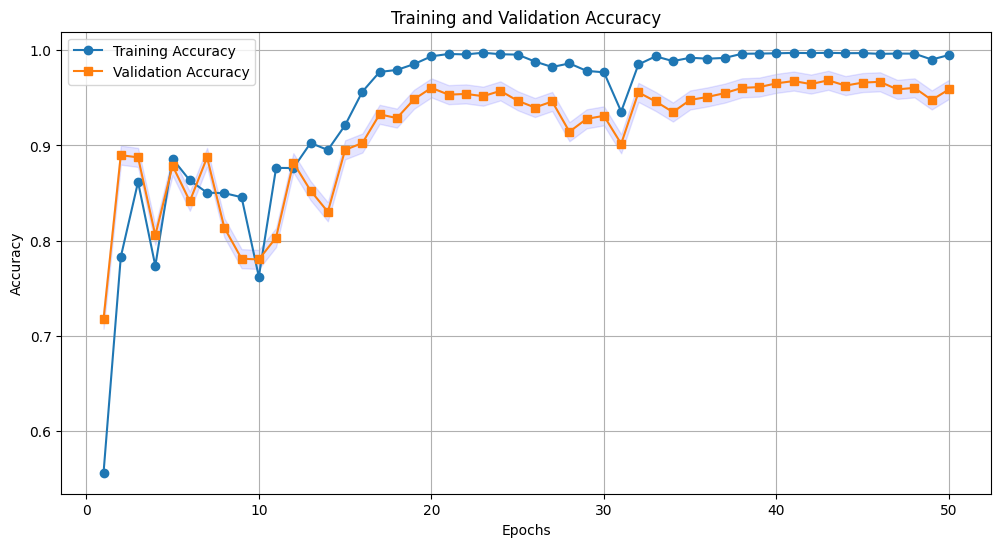

In [10]:
# plt.figure(figsize=(12, 6))
# plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
# plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid()
# plt.savefig('train-val-acc.png')
# plt.show()
epochs_range = range(start_epoch + 1, start_epoch + 1 + len(train_accuracies))  # ✅ Use actual recorded epochs

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='s')
plt.fill_between(epochs_range, 
                 np.array(val_accuracies) - 0.01, 
                 np.array(val_accuracies) + 0.01, 
                 color='b', alpha=0.1)  # Shaded variance region
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig('train-val-acc.png')
plt.show()


Top-K Accuracy

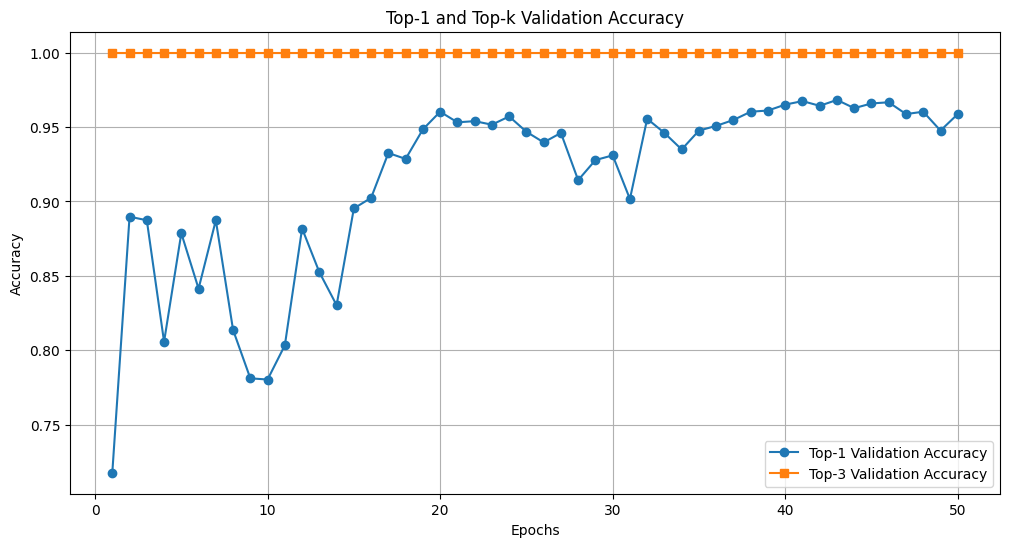

In [11]:
epochs_range = range(start_epoch + 1, start_epoch + 1 + len(val_accuracies))  # ✅ Ensure correct x-axis

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, val_accuracies, label='Top-1 Validation Accuracy', marker='o')
plt.plot(epochs_range, top_k_accuracies, label=f'Top-{top_k} Validation Accuracy', marker='s')
plt.title('Top-1 and Top-k Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig('top-k-accuracy.png')
plt.show()


Regular Confusion Matrix

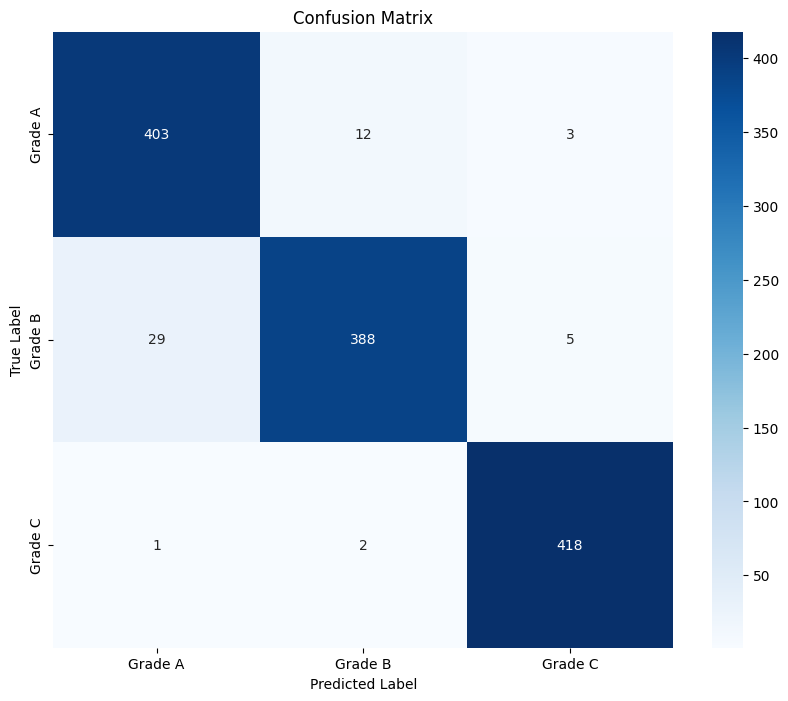

In [12]:
# Confusion matrix (in number)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion-matrix.png')
plt.show()

Normalized Confusion Matrix


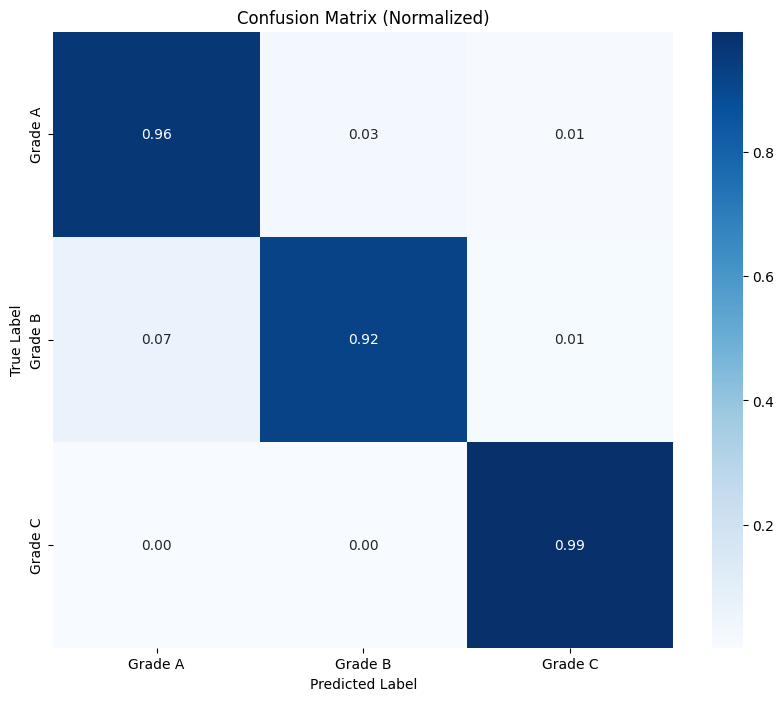

In [13]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # ✅ Prevent division by zero
conf_matrix_normalized = conf_matrix.astype('float') / row_sums

# Confusion matrix
plt.figure(figsize=(10, 8))

# Normalize confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized)")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('norm-confusion-matrix.png')
plt.show()


Test validation Function

In [14]:
# Function to load the best model before testing
def load_best_model(model, best_model_path="best_model.pth"):
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)  # Ensure model is on the right device
    print("✅ Best model loaded successfully!")

# Function to evaluate on the test set
def evaluate_on_test_set(model, test_loader, criterion, class_names, test_dataset):
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    all_test_labels = []
    all_test_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)

            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(preds.cpu().numpy())

    test_loss /= len(test_dataset)
    test_accuracy = test_corrects.double() / len(test_dataset)

    # Calculate metrics
    conf_matrix, accuracy, report = calculate_metrics(all_test_labels, all_test_preds, class_names)

    print(f"\n✅ Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print("🔍 Classification Report:\n", report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Test Set Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('test-confusion-matrix.png')
    plt.show()

✅ Best model loaded successfully!


Evaluating on Test Set: 100%|██████████| 158/158 [01:38<00:00,  1.60it/s]


✅ Test Loss: 0.5803, Test Accuracy: 0.9650
🔍 Classification Report:
               precision    recall  f1-score   support

     Grade A       0.93      0.97      0.95       418
     Grade B       0.97      0.93      0.95       421
     Grade C       1.00      0.99      0.99       419

    accuracy                           0.97      1258
   macro avg       0.97      0.97      0.97      1258
weighted avg       0.97      0.97      0.97      1258



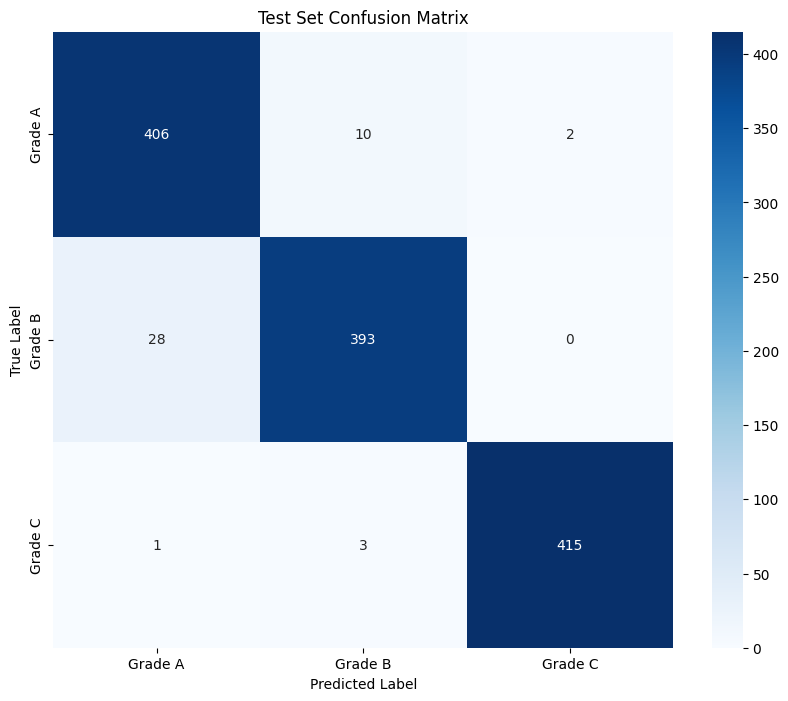

In [15]:
# Load the best model before evaluating
load_best_model(model, "best_model.pth")

# Evaluate on the test set
evaluate_on_test_set(model, test_loader, nn.CrossEntropyLoss(), class_names, test_dataset)